# Spatial reconstruction of the mouse embryo with SageNet
In this notebook present spatial reconstruction of the mouse embryo with SageNet. We use the seqFISH dataset collected by [Lohoff et al. (2022)](https://www.nature.com/articles/s41587-021-01006-2) as the spatial reference. This Spatial Mouse Atlas dataset contains barcoded gene expression measurements for 351 genes in three distinct mouse embryo sagittal sections. We also use combination of a subset of this dataset and the dissociated scRNAseq mouse gastrulation atlas by [Pijuan-Sala et al. (2019)](https://pubmed.ncbi.nlm.nih.gov/30787436/) as the query dataset. For both spatial and scRNAseq datasets, we focus on embryonic day (E)8.5. 

We specifically show how to aggeregate multiple spatial references and build an ensemble SageNet model. 

## Setup
### Install scArches
SageNet is now implemented as a model in the [scarches](https://scarches.readthedocs.io/en/latest/index.html) code base. In order to get the latest developments, we recommend installing the package via github. 

In [ ]:
!git clone https://github.com/theislab/scarches 
%cd scarches
!pip install .

### Install pytorch geometric
SageNet employs pytroch geometric (PyG) to implement graph neural networks (GGNs). We install [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/) and its requirments as instructed [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html). 

PyG's requirements to be installed depend on the torch and cuda versions: 

In [ ]:
import torch; print(torch.__version__)
import torch; print(torch.version.cuda)

1.12.1+cu113
11.3


In [3]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html 
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html 
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 1.1 MB/s 
     |████████████████████████████████| 3.5 MB 1.2 MB/s 


### Other auxilary packages 
We use [squidpy](https://https://squidpy.readthedocs.io/en/stable/) for preprocessing spatial data and [captum](https://https://captum.ai/) for interpreting our GGNs.

In [ ]:
!pip install squidpy
!pip install captum 
!pip install patchworklib

### Import libraries

In [ ]:
import scarches as sca
import scanpy as sc # for plotting 
import anndata as ad # for handling the spatial and single-cell datasets
import random # for setting a random seed 
import numpy as np 
import copy
import squidpy as sq
import pandas as pd
from scarches.models.sagenet.utils import glasso
from matplotlib import *
import patchworklib as pw
import functools

### Cell type colours 

In [3]:
celltype_colours = {
  "Epiblast" : "#635547",
  "Primitive Streak" : "#DABE99",
  "Caudal epiblast" : "#9e6762",
  "PGC" : "#FACB12",
  "Anterior Primitive Streak" : "#c19f70",
  "Notochord" : "#0F4A9C",
  "Def. endoderm" : "#F397C0",
  "Definitive endoderm" : "#F397C0",
  "Gut" : "#EF5A9D",
  "Gut tube" : "#EF5A9D",
  "Nascent mesoderm" : "#C594BF",
  "Mixed mesoderm" : "#DFCDE4",
  "Intermediate mesoderm" : "#139992",
  "Caudal Mesoderm" : "#3F84AA",
  "Paraxial mesoderm" : "#8DB5CE",
  "Somitic mesoderm" : "#005579",
  "Pharyngeal mesoderm" : "#C9EBFB",
  "Splanchnic mesoderm" : "#C9EBFB",
  "Cardiomyocytes" : "#B51D8D",
  "Allantois" : "#532C8A",
  "ExE mesoderm" : "#8870ad",
  "Lateral plate mesoderm" : "#8870ad",
  "Mesenchyme" : "#cc7818",
  "Mixed mesenchymal mesoderm" : "#cc7818",
  "Haematoendothelial progenitors" : "#FBBE92",
  "Endothelium" : "#ff891c",
  "Blood progenitors 1" : "#f9decf",
  "Blood progenitors 2" : "#c9a997",
  "Erythroid1" : "#C72228",
  "Erythroid2" : "#f79083",
  "Erythroid3" : "#EF4E22",
  "Erythroid" : "#f79083",
  "Blood progenitors" : "#f9decf",
  "NMP" : "#8EC792",
  "Rostral neurectoderm" : "#65A83E",
  "Caudal neurectoderm" : "#354E23",
  "Neural crest" : "#C3C388",
  "Forebrain/Midbrain/Hindbrain" : "#647a4f",
  "Spinal cord" : "#CDE088",
  "Surface ectoderm" : "#f7f79e",
  "Visceral endoderm" : "#F6BFCB",
  "ExE endoderm" : "#7F6874",
  "ExE ectoderm" : "#989898",
  "Parietal endoderm" : "#1A1A1A",
  "Unknown" : "#FFFFFF",
  "Low quality" : "#e6e6e6",
  # somitic and paraxial types
  # colour from T chimera paper Guibentif et al Developmental Cell 2021
  "Cranial mesoderm" : "#77441B",
  "Anterior somitic tissues" : "#F90026",
  "Sclerotome" : "#A10037",
  "Dermomyotome" : "#DA5921",
  "Posterior somitic tissues" : "#E1C239",
  "Presomitic mesoderm" : "#9DD84A"
}

#### Setting the torch device
We set the torch device to cuda if it's available.

In [4]:
import torch
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)
print(device)

cuda:0


## Training and Mapping

## The spatial and scRNAseq mouse gastrulation datasets
[Lohoff et al. (2022)](https://www.nature.com/articles/s41587-021-01006-2) carried out a SeqFISH experiment on sagittal sections from three mouse embryos corresponding to embryonic day (E)8.5–8.75 to quantify spatial gene expression at single cell resolution of a pre-selected set of 387 genes. For each embryo section, they captured two 2D planes, 12um apart, yielding a total of 6 spatially-resolved sections. The authors performed cell segmentation, quantified gene expression log-counts, and assigned cell type identities to each cell using a large-scale single cell study of mouse gastrulation [Pijuan-Sala et al. (2019)](https://pubmed.ncbi.nlm.nih.gov/30787436/) as a reference. These two datasets are known as spatial and single-cell mouse gastrulation atlases (MGAs).

This dataset is ideal for evaluating SageNet's performance, since we have access to ground truth spatial coordinates for individual cells over multiple biological replicates, and the tissue structure observed across mouse embryos are varied and complex. We downloaded the gene expression matrix and cell type and spatial location metadata from https://content.cruk.cam.ac.uk/jmlab/SpatialMouseAtlas2020/. 

Prior to analysis, we removed cells that were annotated as “Low quality” by the authors. And we subseted the scRNAseq so that all datasets have the same set of genes. No further preprocessing was performed on the datasets. The filtered seqFISH datsets could be simply downloaded and loaded in the environment by calling `scarches.dataset.MGA_data.seqFISH{embryo}_{layer}()`. The single-cell RNAseq dataset is loaded using `scarches.dataset.MGA_data.scRNAseq()`

In [5]:
adata_seqFISH1_1 = sca.dataset.MGA_data.seqFISH1_1()
adata_seqFISH2_1 = sca.dataset.MGA_data.seqFISH2_1()
adata_seqFISH3_1 = sca.dataset.MGA_data.seqFISH3_1()
adata_seqFISH1_2 = sca.dataset.MGA_data.seqFISH1_2()
adata_seqFISH2_2 = sca.dataset.MGA_data.seqFISH2_2()
adata_seqFISH3_2 = sca.dataset.MGA_data.seqFISH3_2()
adata_scRNAseq   = sca.dataset.scRNAseq()

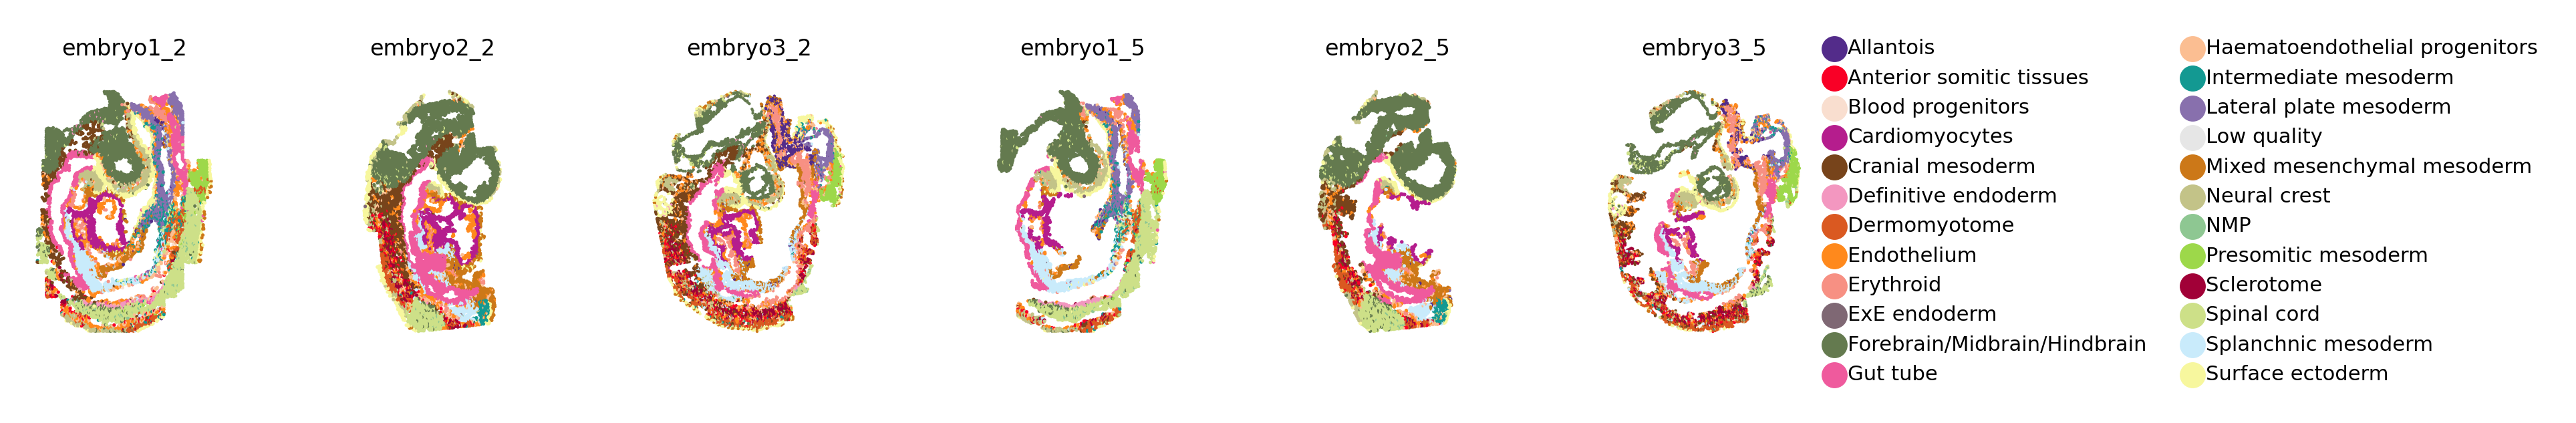

In [6]:
sc.set_figure_params(figsize=(2, 2), fontsize=6)
import functools
adata_seqFISH_list = [adata_seqFISH1_1, adata_seqFISH2_1, adata_seqFISH3_1, adata_seqFISH1_2, adata_seqFISH2_2, adata_seqFISH3_2]
axs = []
for i in range(len(adata_seqFISH_list)):
  axs.append(pw.Brick())
  adata = adata_seqFISH_list[i]
  adata.obsm['spatial'] = np.array(adata.obs[['x','y']])
  sq.gr.spatial_neighbors(adata, coord_type="generic")
  # with rc_context({'figure.figsize': (2, 2)}):
  if(i != len(adata_seqFISH_list)-1):
    sc.pl.spatial(adata, color='cell_type', palette=celltype_colours, frameon=False, spot_size=.1, title=pd.unique(adata.obs['embryo']), ax=axs[i], legend_loc=None)
  else:
    sc.pl.spatial(adata, color='cell_type', palette=celltype_colours, frameon=False, spot_size=.1, title=pd.unique(adata.obs['embryo']), ax=axs[i])
plots = functools.reduce(lambda a, b: a+b, axs)
plots.savefig()
# 

### Training with one reference dataset

As the basic functionality of SageNet, we start with training the model on only one spatial reference. We take embryo 1 layer 1 (`seqFISH1_1`) as the spatial reference.

#### Building the gene interaction network
SageNet model uses a gene interaction network (across all cells in the reference dataset) to train the GNN (see the [preprint](https://www.biorxiv.org/content/10.1101/2022.04.14.488419v1)). We use a utility fuction impelemented in the package for the graphical LASSO ([GLASSO](https://en.wikipedia.org/wiki/Graphical_lasso)) algorithm to estimate the gene interaction network. The funciton takes a grid of regulatrization parameters and does a cross validation to find the optimal parameter (see [this](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.GraphicalLassoCV.html)).

In [7]:
glasso(adata_seqFISH1_1, [0.25, 0.5])
adata_seqFISH1_1

AnnData object with n_obs × n_vars = 10045 × 350
    obs: 'cell_id', 'embryo', 'x', 'y', 'UMAP1', 'UMAP2', 'cell_type', 'res_0.05', 'class_'
    uns: 'X_name', 'celltype_colours', 'spatial_neighbors', 'cell_type_colors'
    obsm: 'spatial'
    varm: 'adj'
    obsp: 'spatial_connectivities', 'spatial_distances'

The adjacency matrix of the built graph has added under the name `adj` to the  `varm` section of the annData object.

#### Spatial partitioning of the reference
The spatial reference should be partinitioned into distinct spatial neighborhood. The GGNs learn to map the dissociated query cells to those partitions. We use the [`leiden`](https://www.nature.com/articles/s41598-019-41695-z) algorithm on the spatial graph created by [`squidpy`](https://squidpy.readthedocs.io/en/stable/). We run the partitioning at 3 different resolutions. The idea is to capture different granularities in space.

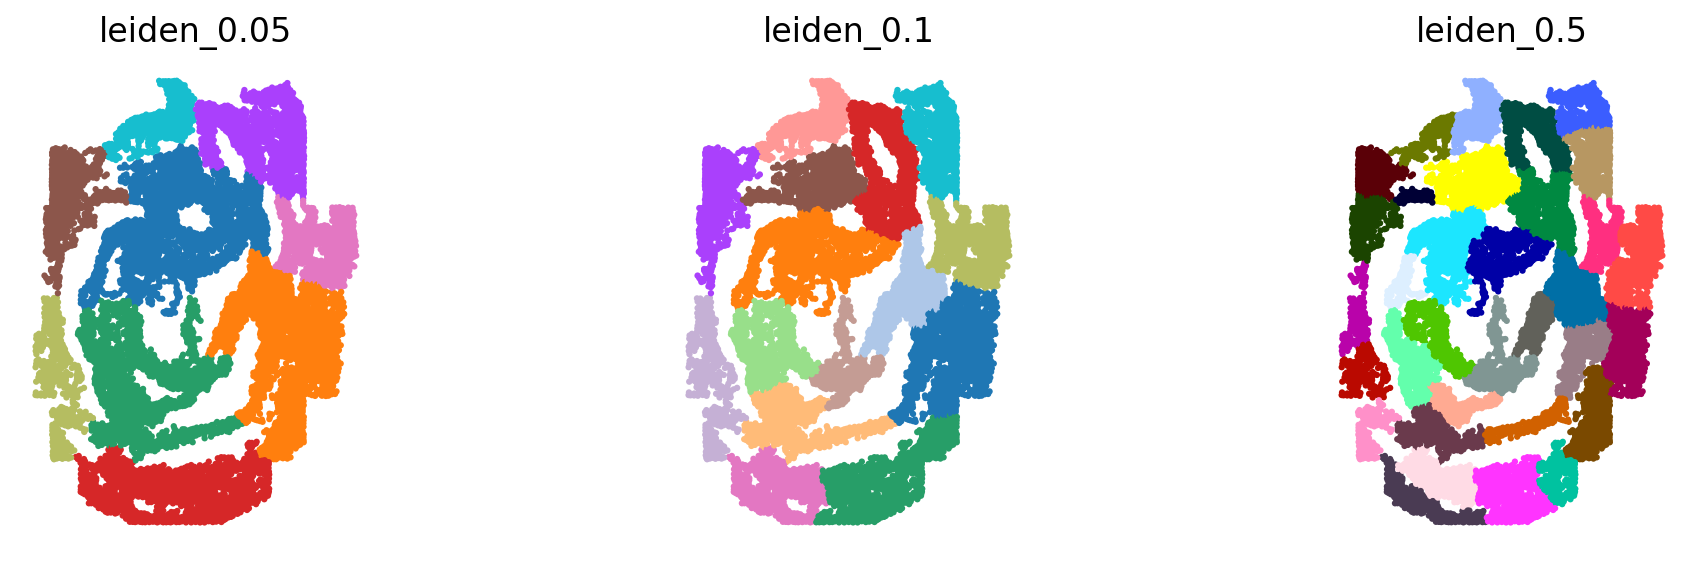

AnnData object with n_obs × n_vars = 10045 × 350
    obs: 'cell_id', 'embryo', 'x', 'y', 'UMAP1', 'UMAP2', 'cell_type', 'res_0.05', 'class_', 'leiden_0.05', 'leiden_0.1', 'leiden_0.5'
    uns: 'X_name', 'celltype_colours', 'spatial_neighbors', 'cell_type_colors', 'leiden', 'leiden_0.05_colors', 'leiden_0.1_colors', 'leiden_0.5_colors'
    obsm: 'spatial'
    varm: 'adj'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [8]:
sc.set_figure_params(figsize=(4, 4), fontsize=15)
sc.tl.leiden(adata_seqFISH1_1, resolution=.05, random_state=0, key_added='leiden_0.05', adjacency=adata_seqFISH1_1.obsp["spatial_connectivities"])
sc.tl.leiden(adata_seqFISH1_1, resolution=.1, random_state=0, key_added='leiden_0.1', adjacency=adata_seqFISH1_1.obsp["spatial_connectivities"])
sc.tl.leiden(adata_seqFISH1_1, resolution=.5, random_state=0, key_added='leiden_0.5', adjacency=adata_seqFISH1_1.obsp["spatial_connectivities"])
# with rc_context({'figure.figsize': (2, 2)}):
sc.pl.spatial(adata_seqFISH1_1, color=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'], frameon=False, ncols=3, spot_size=.1, title=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'],  legend_loc=None)
adata_seqFISH1_1

The partitionings have been added to the `obs` section. 

#### Training the model
We now define the SageNet model object:

In [9]:
sg_obj = sca.models.sagenet(device=device)

Finally, we train the model by feeding in the reference mode and specefying the `obs` columns containing the partitionings. The model trains one GNN for each partitioning:

In [10]:
import torch_geometric.data as geo_dt

In [11]:
sg_obj.train(adata_seqFISH1_1, comm_columns=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'], tag='seqFISH_ref1', epochs=15, verbose = False, importance=True)

By setting `importance = True` we compute the feature (here gene) importances in training. A column specifying these importance values has been added to the adata. This gives us the *Spatially Informative Genes (SIGs)*:

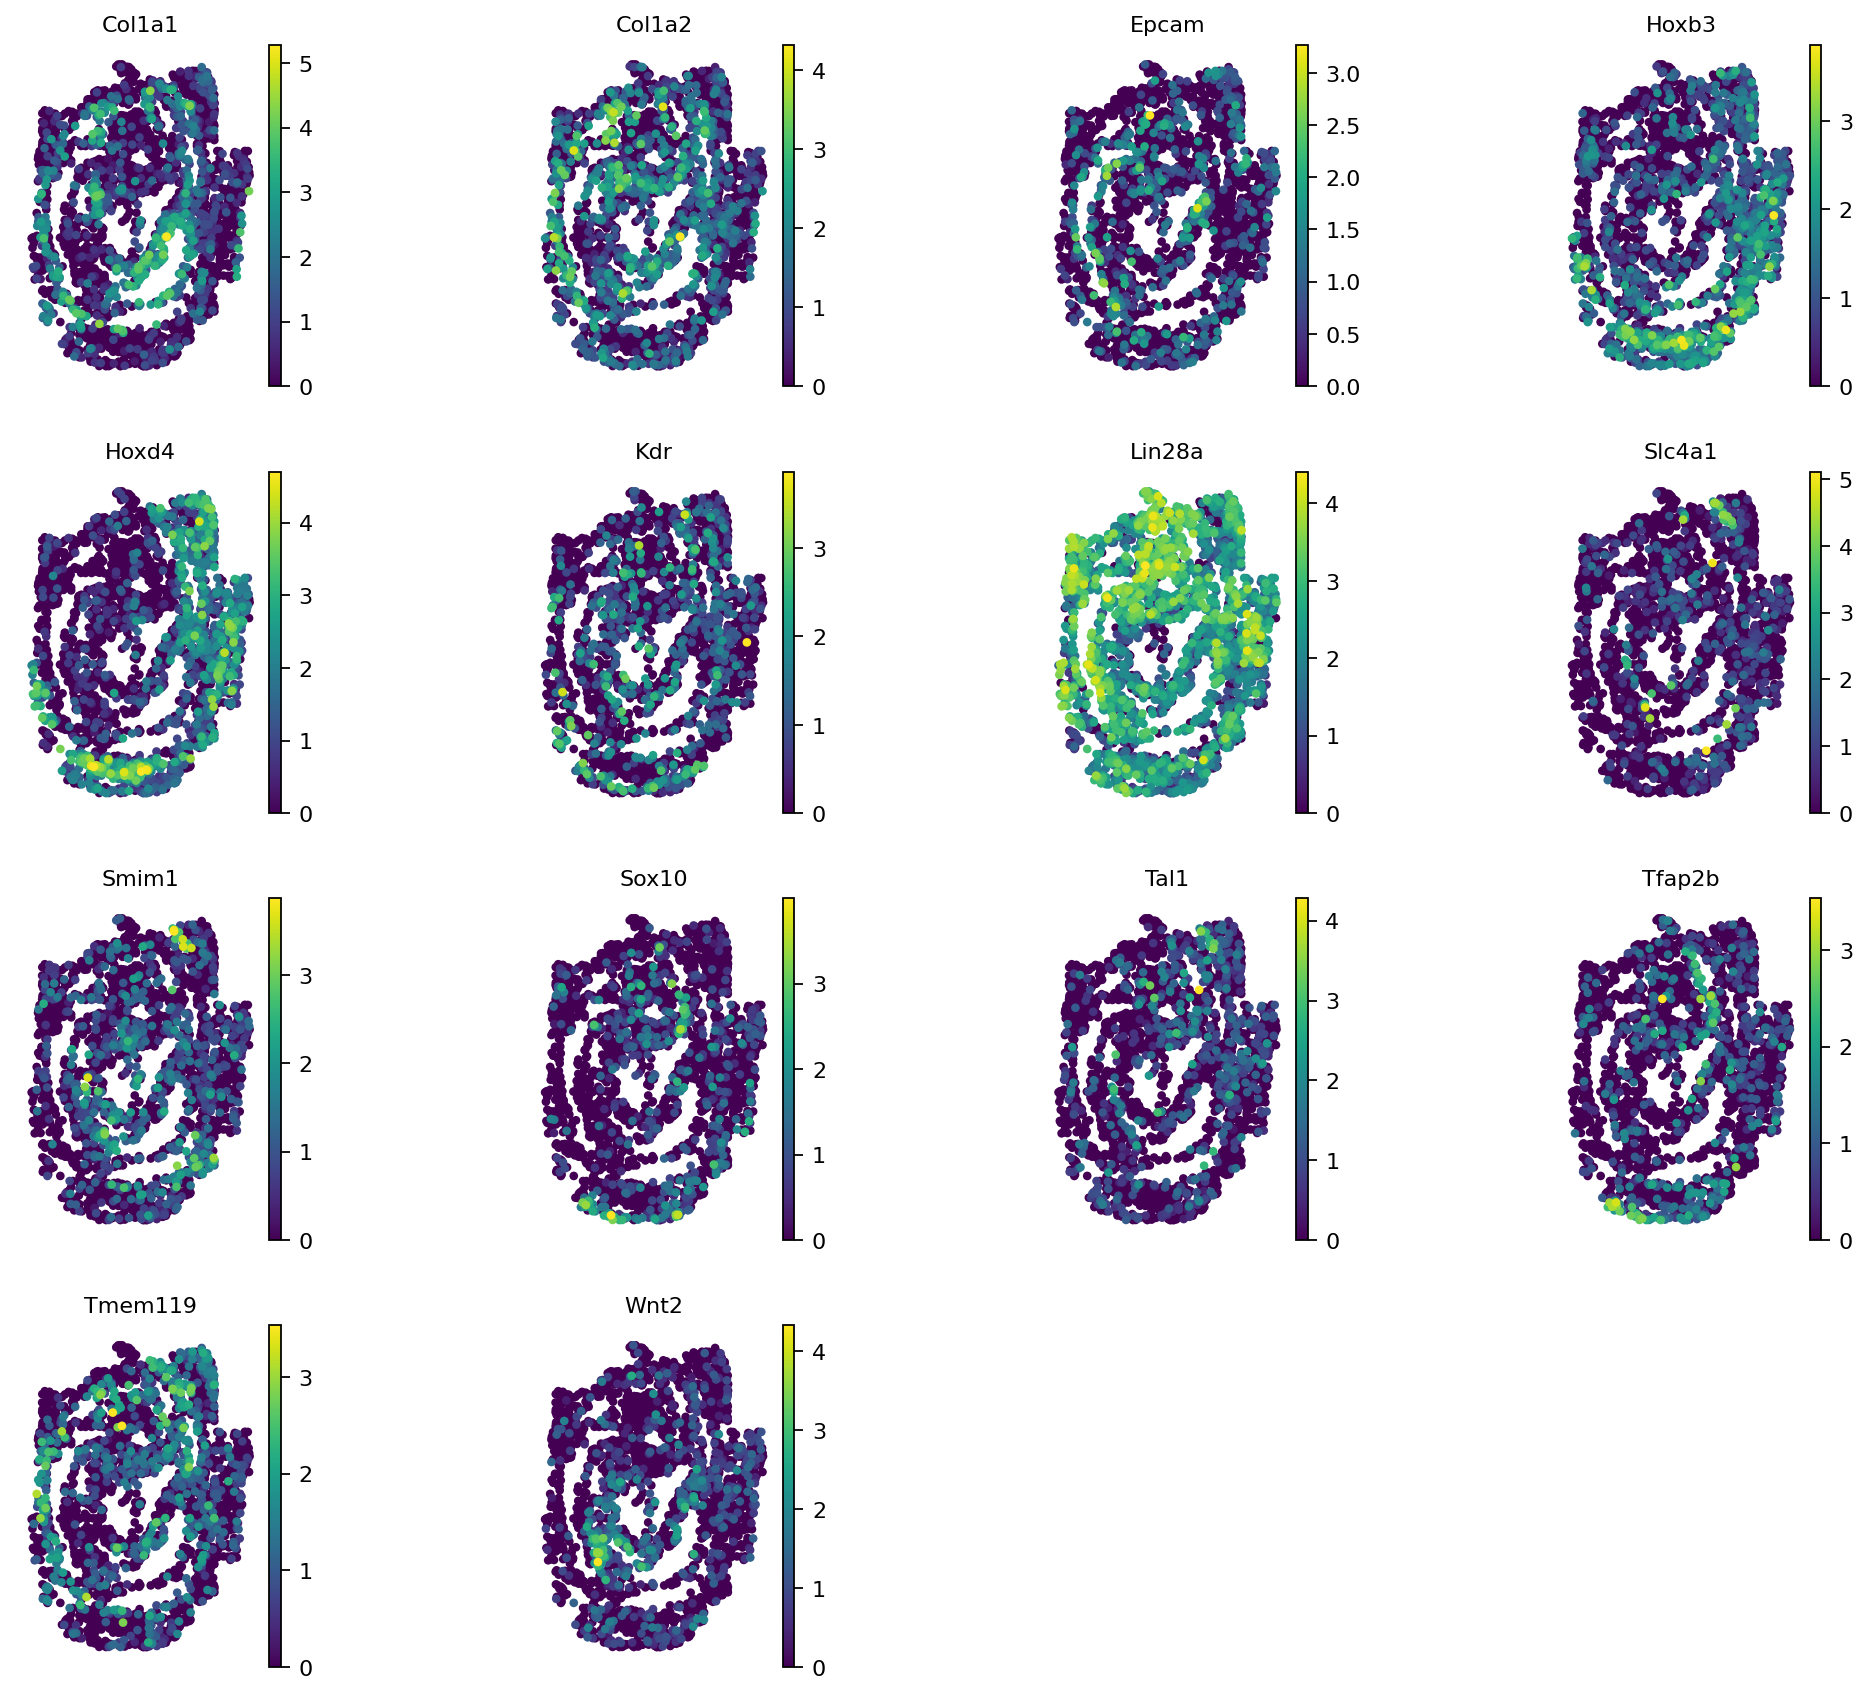

In [12]:
sc.set_figure_params(figsize=(3, 3), fontsize=10)
from copy import copy
ind   = np.where(adata_seqFISH1_1.var['seqFISH_ref1_importance'] == 0)[0]
SIGs1 = list(adata_seqFISH1_1.var_names[ind])
adata_r = copy(adata_seqFISH1_1)
sc.pp.subsample(adata_r, fraction=0.25)
# with rc_context({'figure.figsize': (2, 2)}):
sc.pl.spatial(adata_r, color=SIGs1, ncols=4, spot_size=0.2, legend_loc=None, frameon=False)

#### Saving the trained model
We can save the trained model as a folder:

In [13]:
!mkdir models
!mkdir models/seqFISH_ref
sg_obj.save_as_folder('models/seqFISH_ref')
%ls -l models/seqFISH_ref

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘models/seqFISH_ref’: File exists
total 2228
-rw-r--r-- 1 root root 533016 Sep 14 14:22 seqFISH_ref1_leiden_0.05.h5ad
-rw-r--r-- 1 root root 108999 Sep 14 14:22 seqFISH_ref1_leiden_0.05.pickle
-rw-r--r-- 1 root root 533016 Sep 14 14:22 seqFISH_ref1_leiden_0.1.h5ad
-rw-r--r-- 1 root root 176199 Sep 14 14:22 seqFISH_ref1_leiden_0.1.pickle
-rw-r--r-- 1 root root 533016 Sep 14 14:22 seqFISH_ref1_leiden_0.5.h5ad
-rw-r--r-- 1 root root 377927 Sep 14 14:22 seqFISH_ref1_leiden_0.5.pickle


The function above saves the `torch` neural networks as well as the adjancency matrices used for training the model in a folder. For reusing the model, one can load the model into another SageNet object:

In [14]:
sg_obj_load = sca.models.sagenet(device=device)
sg_obj_load.load_from_folder('models/seqFISH_ref')

### Mapping the query dataset
We can now feed the query dataset into the trained model to get the predicted cell-cell spatial distances. Here, we take the single-cell dataset as the query dataset:

In [15]:
sg_obj_load.load_query_data(adata_scRNAseq)

In [16]:
adata_scRNAseq

AnnData object with n_obs × n_vars = 16909 × 350
    obs: 'cell_id', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'sizeFactor', 'cell_type', 'class_', 'pred_seqFISH_ref1_leiden_0.5', 'ent_seqFISH_ref1_leiden_0.5', 'pred_seqFISH_ref1_leiden_0.1', 'ent_seqFISH_ref1_leiden_0.1', 'pred_seqFISH_ref1_leiden_0.05', 'ent_seqFISH_ref1_leiden_0.05'
    uns: 'X_name', 'cell_types', 'celltype_colours'
    obsm: 'dist_map'

The predicted cell-cell distance matrix has been added to the query adata in the `obsm` section under the name `dist_map`. We use t-SNE to map the cells based on this distance matrix in 2 dimensions:


In [17]:
dist_adata = ad.AnnData(adata_scRNAseq.obsm['dist_map'], obs = adata_scRNAseq.obs)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(dist_adata.X, n_neighbors=50, metric='precomputed')
dist_adata.obsp['distances'], dist_adata.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    dist_adata.shape[0],
    50 # change to neighbors you plan to use
)
sc.pp.neighbors(dist_adata, metric='precomputed', use_rep='X')
sc.tl.tsne(dist_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


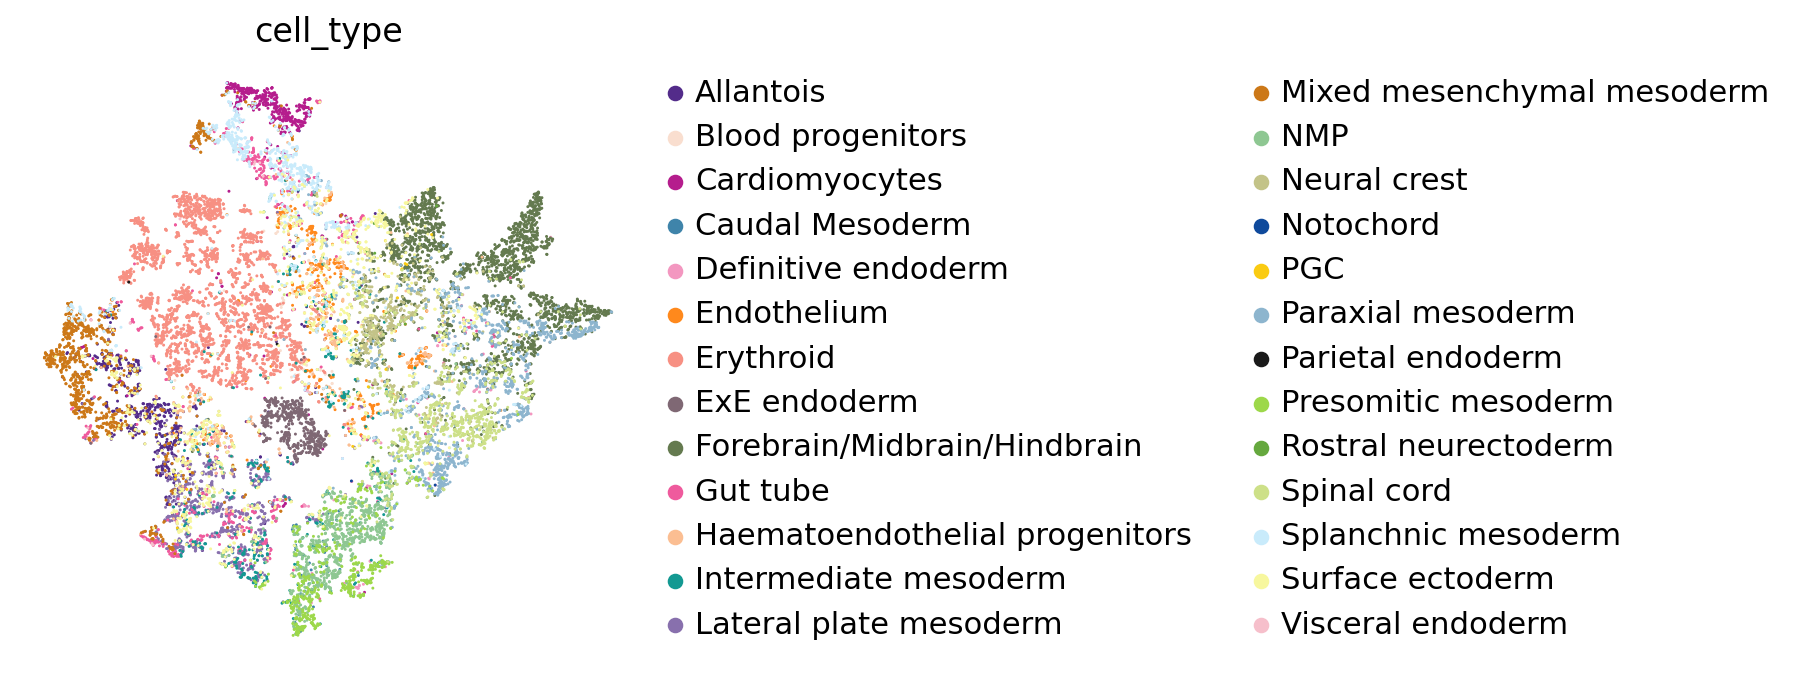

In [18]:
sc.set_figure_params(figsize=(5, 5), fontsize=15)
sc.pl.tsne(dist_adata, color=['cell_type'], palette=celltype_colours, frameon=False)

In [19]:
cluster_counts = adata_scRNAseq.obs['cell_type'].value_counts()
adata_scRNAseq = adata_scRNAseq[adata_scRNAseq.obs['cell_type'].isin( cluster_counts[cluster_counts>50].index)]
dist_adata = dist_adata[dist_adata.obs['cell_type'].isin( cluster_counts[cluster_counts>50].index)]

Now we can look at the expression of the SIGs (introduced above) at the 2D reconstructed space:

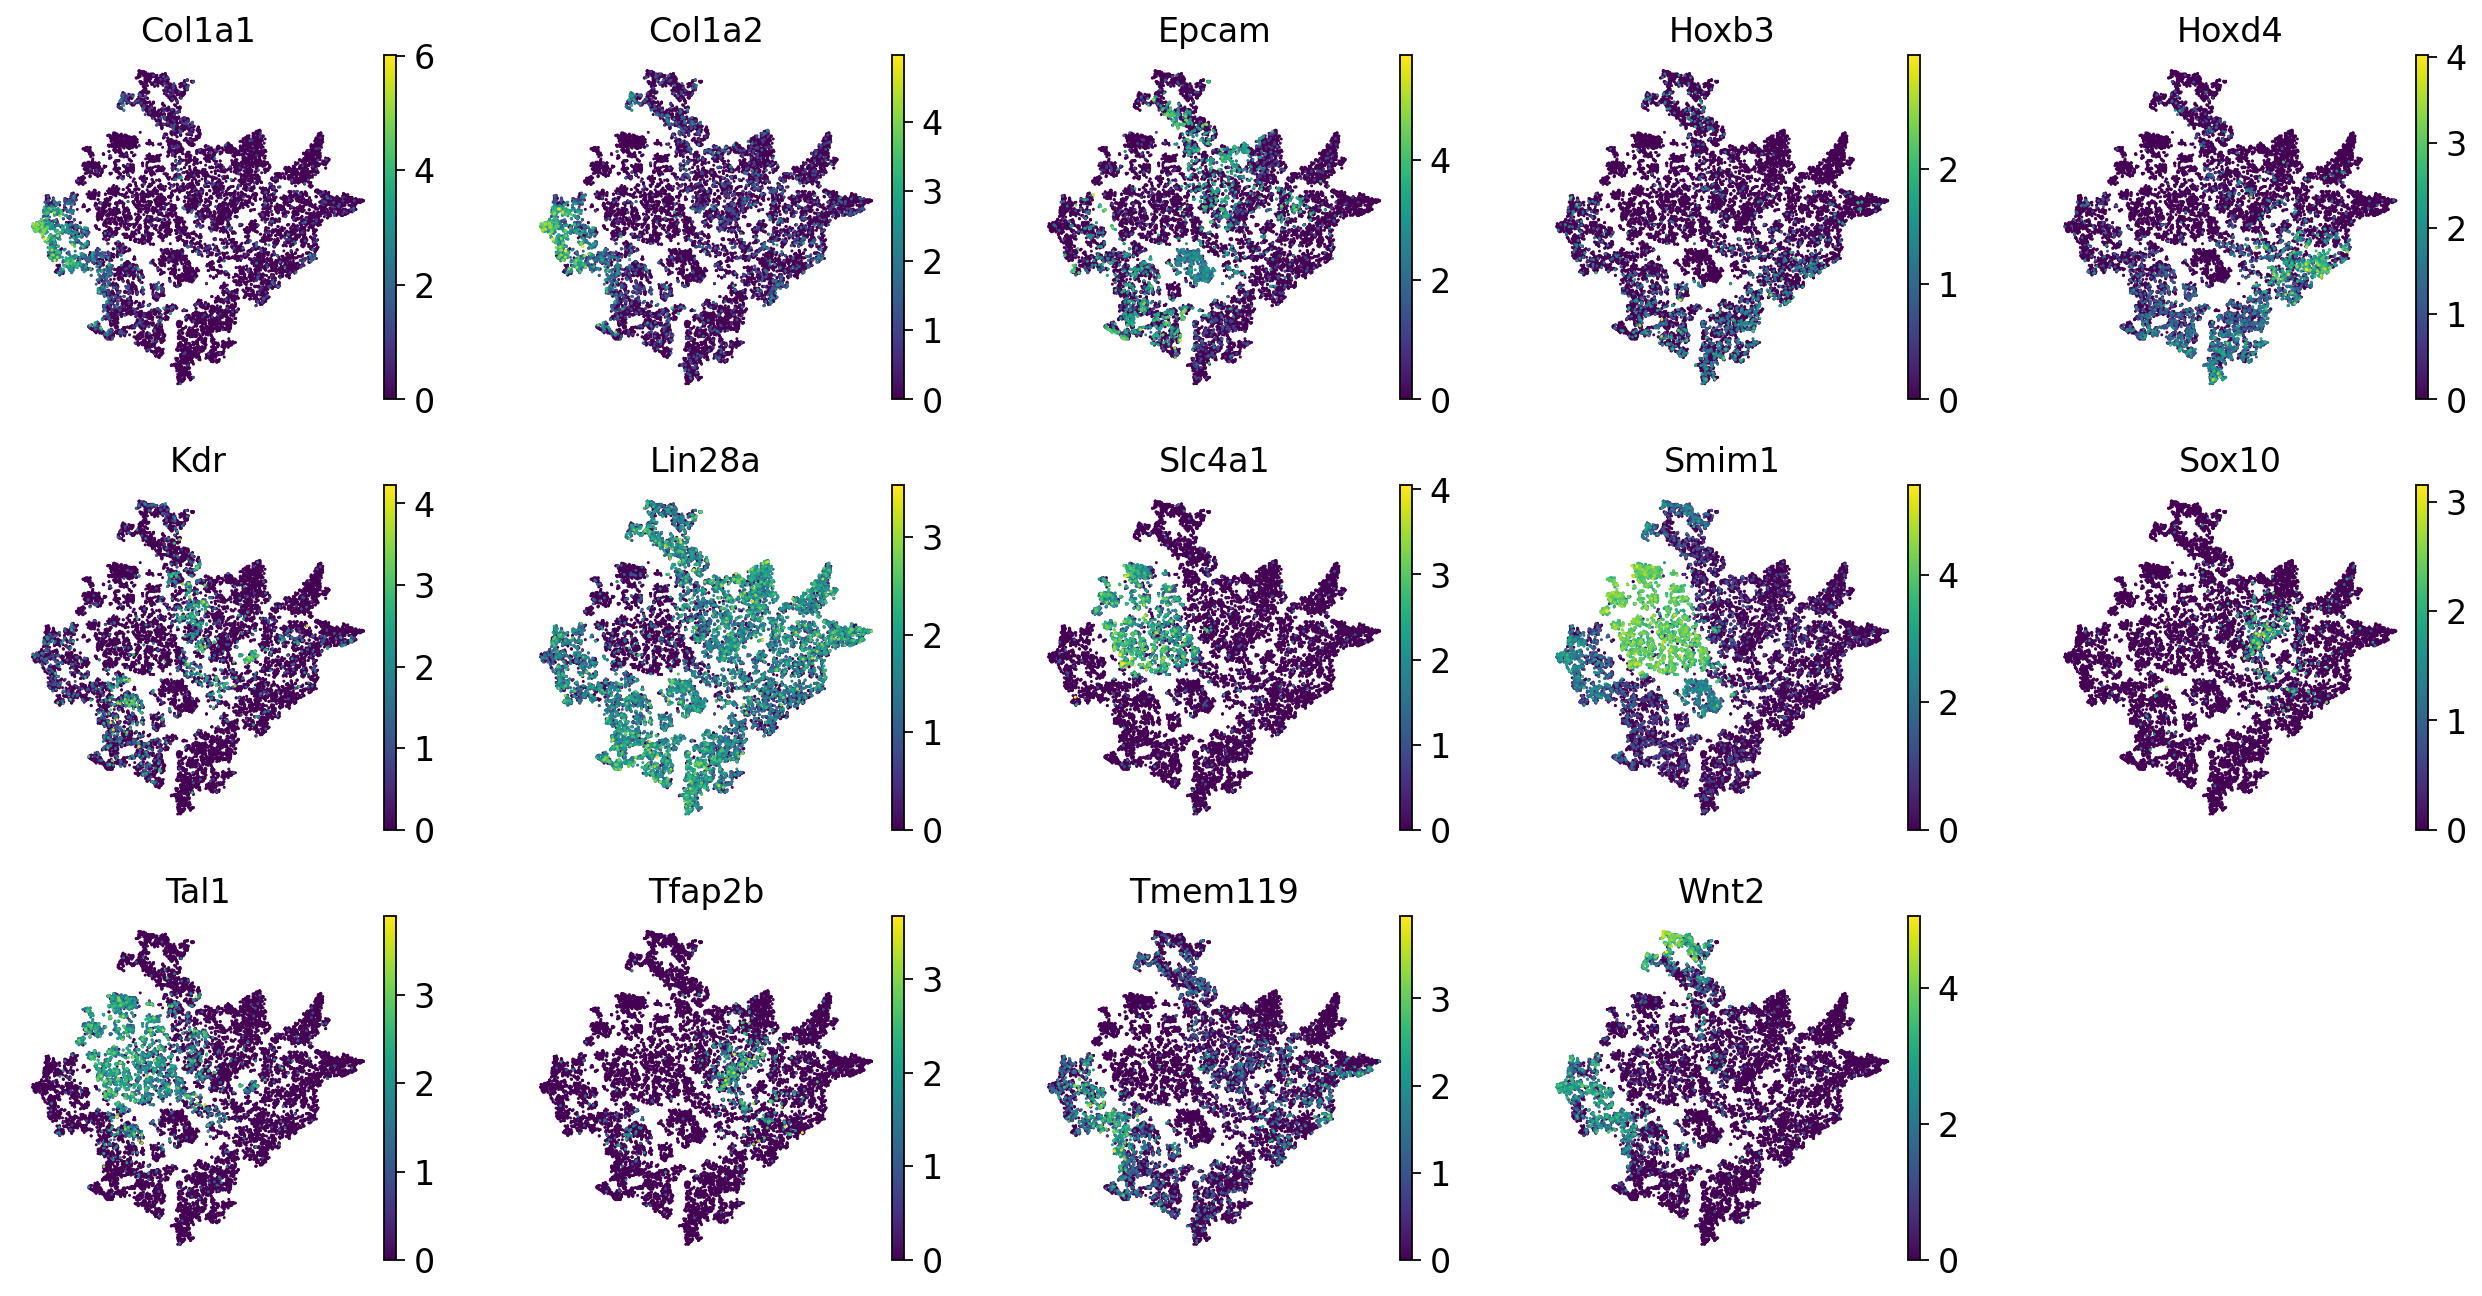

In [20]:
adata_scRNAseq.obsm['tsne'] = dist_adata.obsm['X_tsne']
sc.set_figure_params(figsize=(3, 3), fontsize=15)
sc.pl.tsne(adata_scRNAseq, color=SIGs1, ncols=5, legend_loc=None, frameon=False)

         Falling back to preprocessing with `sc.pp.pca` and default params.


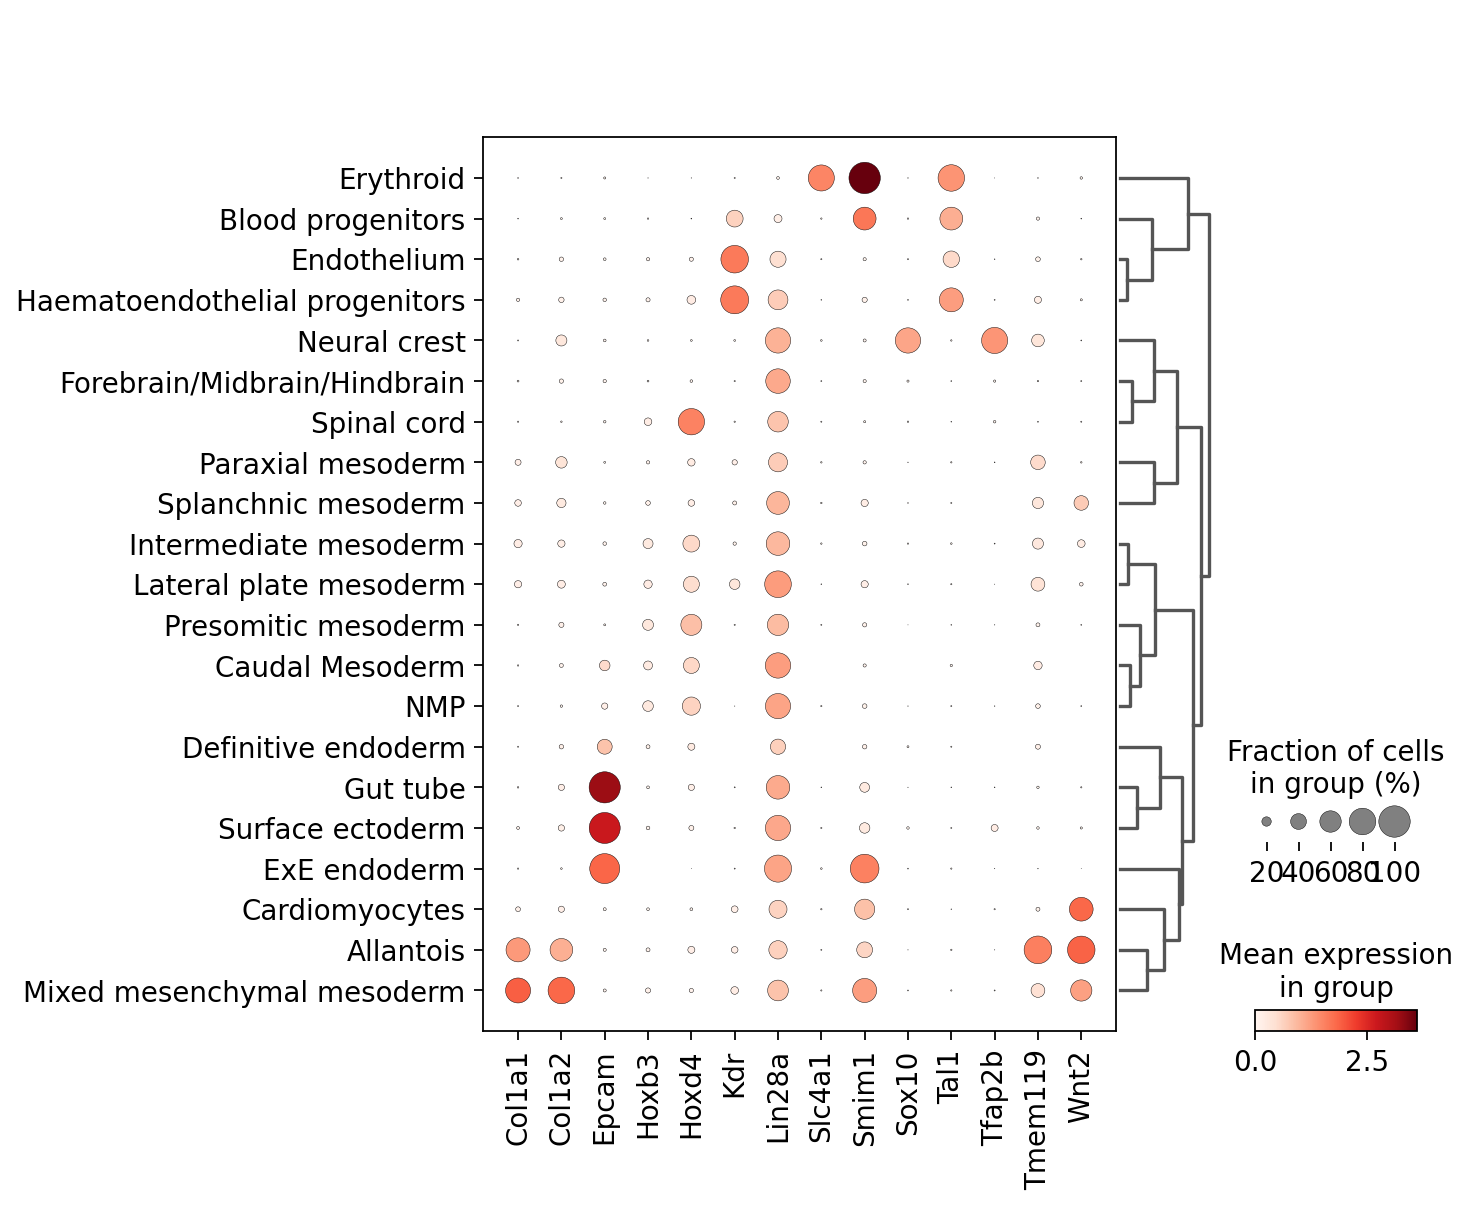

In [21]:
sc.set_figure_params(figsize=(5, 5), fontsize=15)
sc.pl.dotplot(adata_scRNAseq, SIGs1, groupby='cell_type', dendrogram=True)

The model outputs a confidence score for each of the cells per GGN (namely per partitioning). This score is between 0 and 1, and higher the less confident is the model to map the corresponding query cell. Therfore, one can summarize the confidence scores from all trained GGNs:

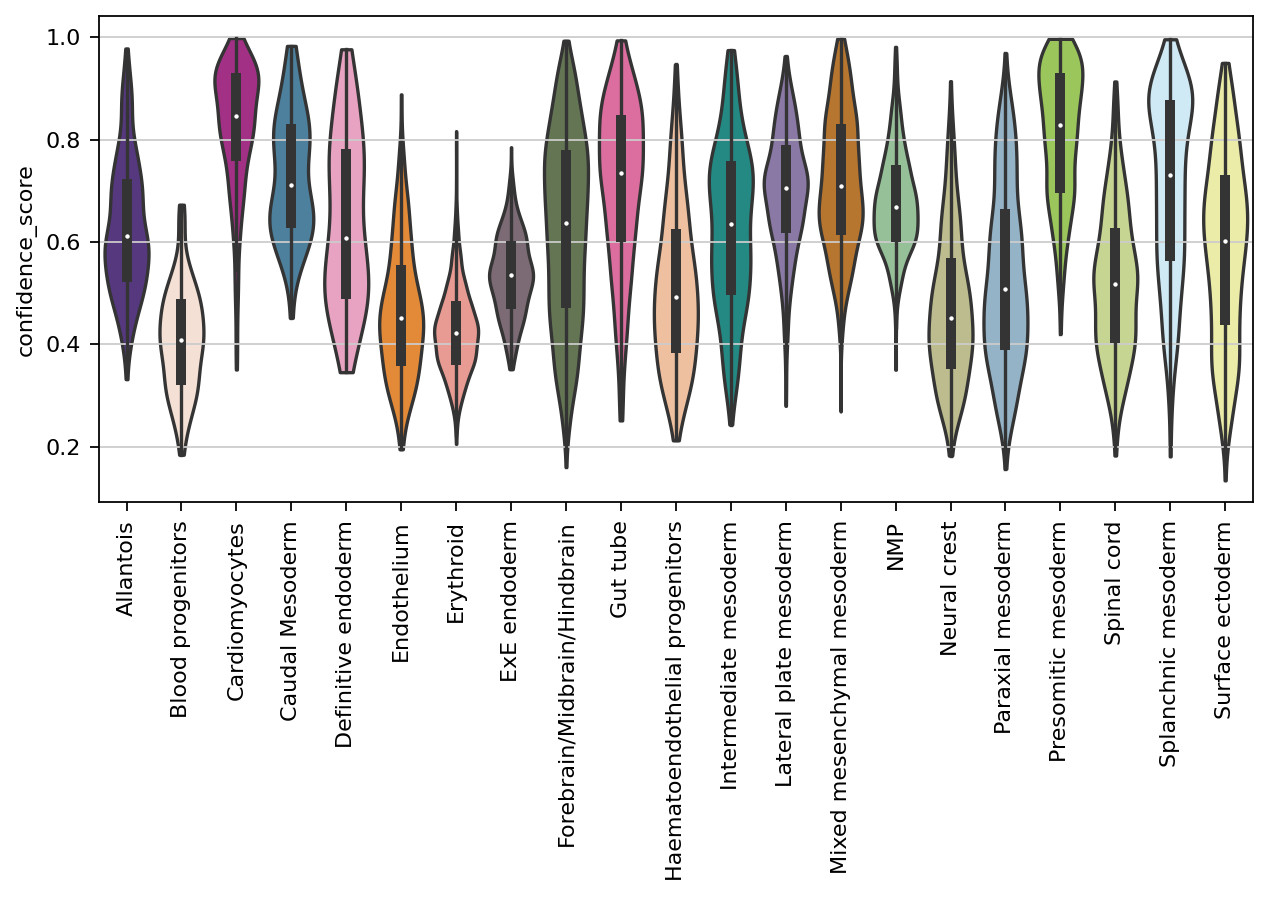

In [22]:
sc.set_figure_params(figsize=(8, 4), fontsize=10)
adata_scRNAseq.obs['confidence_score'] = (3 - (adata_scRNAseq.obs['ent_seqFISH_ref1_leiden_0.05'] + adata_scRNAseq.obs['ent_seqFISH_ref1_leiden_0.1'] + adata_scRNAseq.obs['ent_seqFISH_ref1_leiden_0.5']))/3
# with rc_context({'figure.figsize': (4, 2)}):
sc.pl.violin(adata_scRNAseq, ['confidence_score'], groupby='cell_type', palette=celltype_colours, stripplot=False, inner='box', rotation=90)

### Training with multiple spatial references 
Now we add 2 other spatial references to the model. These are seqFISH datasets from other mouse embryos, `seqFISH2_1` and `seqFISH3_1`. We first perform the same preprocessing steps: 

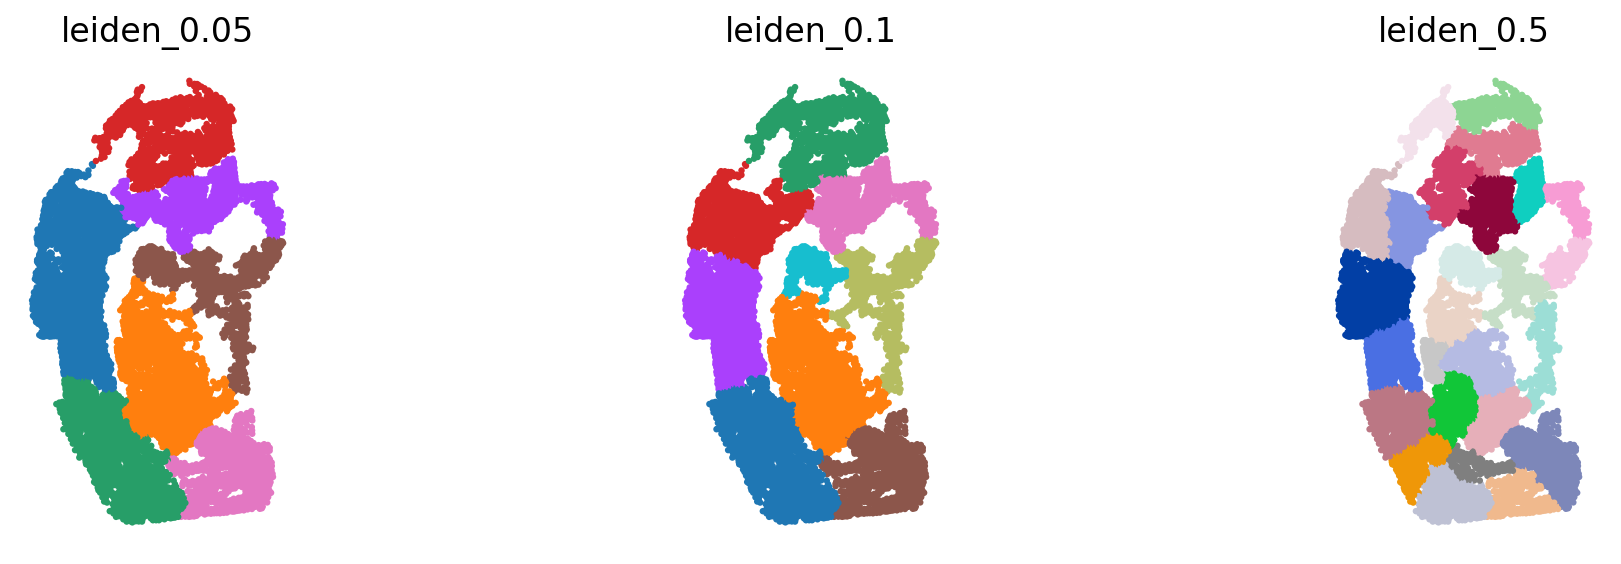

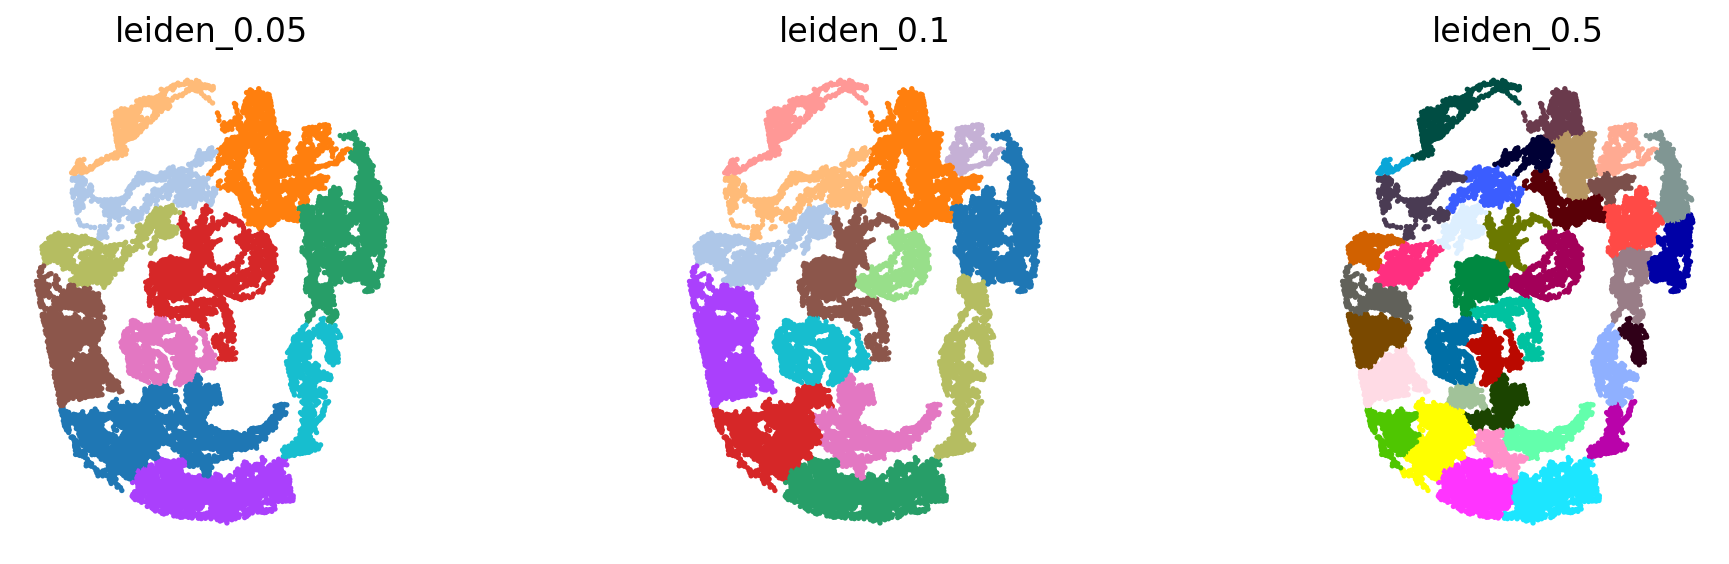

In [23]:
glasso(adata_seqFISH2_1, [0.25, 0.5])
sc.tl.leiden(adata_seqFISH2_1, resolution=.05, random_state=0, key_added='leiden_0.05', adjacency=adata_seqFISH2_1.obsp["spatial_connectivities"])
sc.tl.leiden(adata_seqFISH2_1, resolution=.1, random_state=0, key_added='leiden_0.1', adjacency=adata_seqFISH2_1.obsp["spatial_connectivities"])
sc.tl.leiden(adata_seqFISH2_1, resolution=.5, random_state=0, key_added='leiden_0.5', adjacency=adata_seqFISH2_1.obsp["spatial_connectivities"])

glasso(adata_seqFISH3_1, [0.25, 0.5])
sc.tl.leiden(adata_seqFISH3_1, resolution=.05, random_state=0, key_added='leiden_0.05', adjacency=adata_seqFISH3_1.obsp["spatial_connectivities"])
sc.tl.leiden(adata_seqFISH3_1, resolution=.1, random_state=0, key_added='leiden_0.1', adjacency=adata_seqFISH3_1.obsp["spatial_connectivities"])
sc.tl.leiden(adata_seqFISH3_1, resolution=.5, random_state=0, key_added='leiden_0.5', adjacency=adata_seqFISH3_1.obsp["spatial_connectivities"])
sc.set_figure_params(figsize=(4, 4), fontsize=15)
sc.pl.spatial(adata_seqFISH2_1, color=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'], frameon=False, ncols=3, spot_size=.1, title=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'],  legend_loc=None)
sc.pl.spatial(adata_seqFISH3_1, color=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'], frameon=False, ncols=3, spot_size=.1, title=['leiden_0.05', 'leiden_0.1', 'leiden_0.5'],  legend_loc=None)

In [24]:
# !mkdir models
# !mkdir models/seqFISH_ref
sg_obj.save_as_folder('models/seqFISH_ref')
%ls -l models/seqFISH_ref

total 2228
-rw-r--r-- 1 root root 533016 Sep 14 14:28 seqFISH_ref1_leiden_0.05.h5ad
-rw-r--r-- 1 root root 108999 Sep 14 14:28 seqFISH_ref1_leiden_0.05.pickle
-rw-r--r-- 1 root root 533016 Sep 14 14:28 seqFISH_ref1_leiden_0.1.h5ad
-rw-r--r-- 1 root root 176199 Sep 14 14:28 seqFISH_ref1_leiden_0.1.pickle
-rw-r--r-- 1 root root 533016 Sep 14 14:28 seqFISH_ref1_leiden_0.5.h5ad
-rw-r--r-- 1 root root 377927 Sep 14 14:28 seqFISH_ref1_leiden_0.5.pickle


The sagenet model object now includes more models added corresponding to the new spatial references. 

#### Mapping the query dataset
Now let's map the query dataset once again with the new ensemble model:

         Falling back to preprocessing with `sc.pp.pca` and default params.


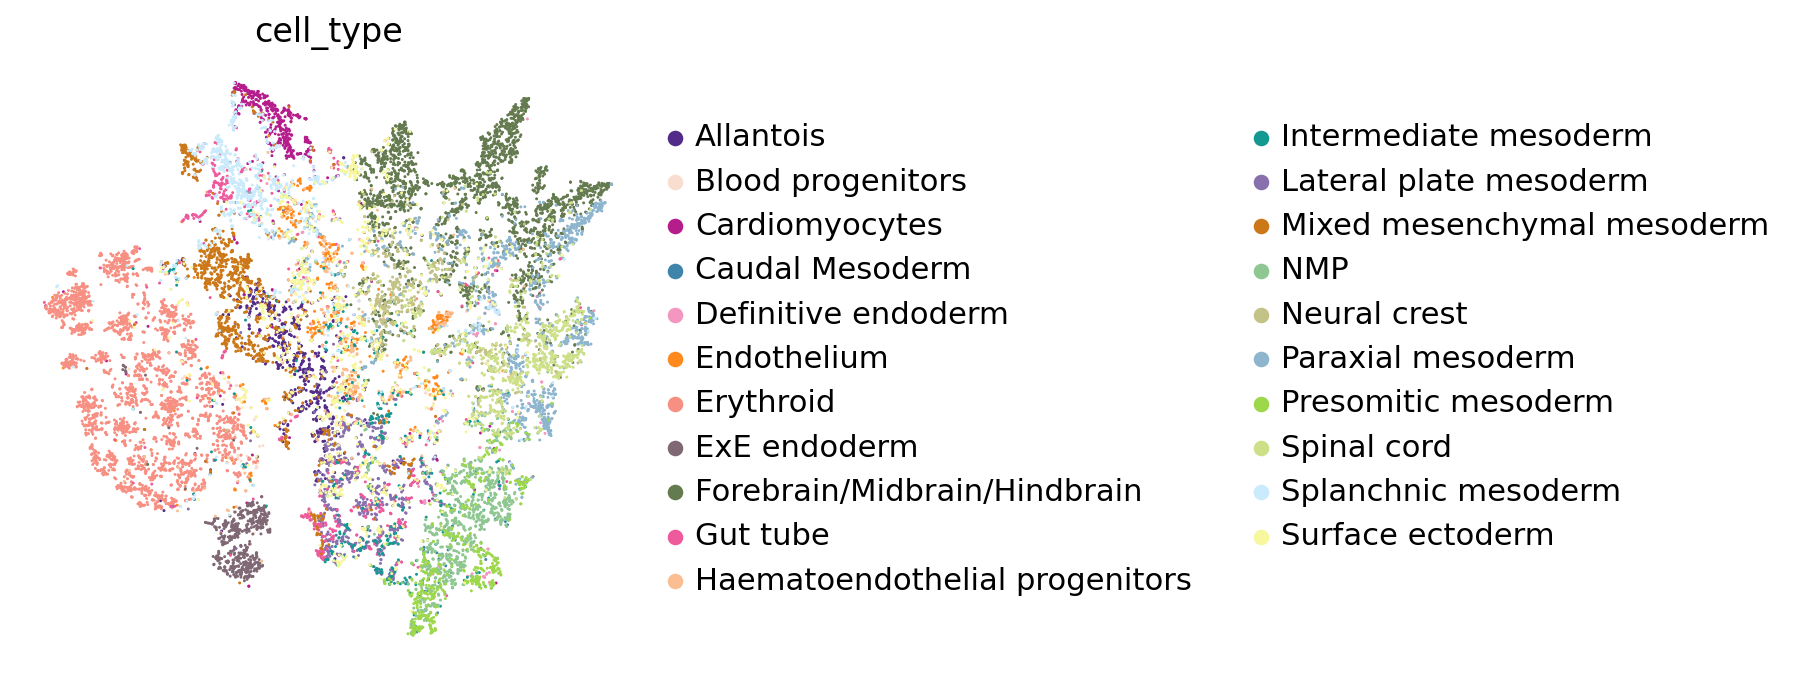

In [25]:
sc.set_figure_params(figsize=(5, 5), fontsize=15)
sg_obj_load.load_query_data(adata_scRNAseq)

dist_adata = ad.AnnData(adata_scRNAseq.obsm['dist_map'], obs = adata_scRNAseq.obs)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(dist_adata.X, n_neighbors=50, metric='precomputed')
dist_adata.obsp['distances'], dist_adata.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    dist_adata.shape[0],
    50 # change to neighbors you plan to use
)
sc.pp.neighbors(dist_adata, metric='precomputed', use_rep='X')
sc.tl.tsne(dist_adata)

sc.pl.tsne(dist_adata, color=['cell_type'], palette=celltype_colours, frameon=False)